# Import packages and functions

In [1]:
%matplotlib inline
%run utils.py

In [2]:
FILE_PATH_SHORT = 'input/short_simulation.mat'
FILE_PATH_LONG = 'input/long_simulation.mat'

# Convert Matlab file into Pandas Data frame

In [3]:
# read Matlab file and convert into DataFrame Simulation parameters i.e. independent variables
simulation = read_and_save_simulation(FILE_PATH_LONG)

['__header__', '__version__', '__globals__', 'Simulation']
Matlab file is converted to DataFrame
Independent variables have been read :  (5000000, 7)
Simulation Result is read


## Descriptive statistics

In [9]:
print('Dimension of the simulation : ', simulation.shape)
simulation.head()

Dimension of the simulation :  (20000000, 10)


,id,len,distance_source,con,snr,depth_1,depth_2,localization_source,connectivity_estimate,y
0,0.0,1179.0,89.452006,1.0,0.657092,93.914788,46.159509,0.0,0.0,1.0
1,0.0,1179.0,89.452006,1.0,0.657092,93.914788,46.159509,0.0,1.0,1.0
2,0.0,1179.0,89.452006,1.0,0.657092,93.914788,46.159509,1.0,0.0,1.0
3,0.0,1179.0,89.452006,1.0,0.657092,93.914788,46.159509,1.0,1.0,1.0
4,1.0,1214.0,61.476372,0.0,0.806123,65.795515,7.270739,0.0,0.0,0.5


## Target variable

In [9]:
# frequency of the target variable: class balance
simulation.y.value_counts(normalize=True) * 100

0.0    55.206085
1.0    37.256930
0.5     7.536985
Name: y, dtype: float64

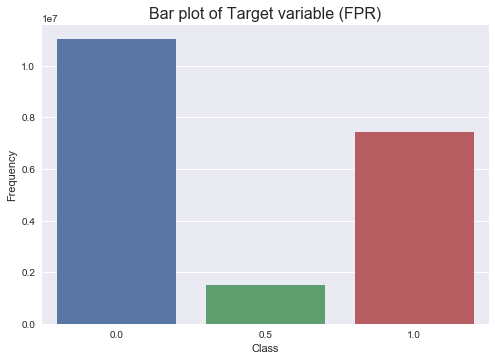

In [8]:
# class balance: barplot
sns.countplot(simulation.y)
plt.title('Bar plot of Target variable (FPR)', fontsize=16)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.savefig('figures/class_balance.png')

Based on class distribution we can conclude that classes are imbalanced. So we will combine `0.5` and `1.0` classes into one class. Now, we have binary classification problem.

### Convert Multi-class into Binary

In [4]:
# convert target variable into binary class
simulation['y'] = simulation.y.apply(lambda x: 1.0 if x == 0.5 else x)

In [8]:
# class balance
simulation.y.value_counts(normalize=True) * 100

0.0    55.206085
1.0    44.793915
Name: y, dtype: float64

In [5]:
# get column names for predictor variables
predictor_columns = [
    'len', 
    'distance_source', 
    'snr', 
    'depth_1', 
    'depth_2', 
    'localization_source', 
    'connectivity_estimate'
]

# Feature Selection

## Univariate selection
Statistical tests can be used to select those features that have the strongest relationships with the output variable.

The scikit-learn library provides the SelectKBest class, which can be used with a suite of different statistical tests to select a specific number of features.

The following example uses the chi squared (chi^2) statistical test for non-negative features.

In [6]:
# convert continuous values into labels
le = LabelEncoder()
y = le.fit_transform(simulation.y.values)

# predictor variables
X = simulation.loc[:, predictor_columns]

These objects take as input a scoring function that returns univariate scores and p-values (or only scores for SelectKBest and SelectPercentile):

* For regression: `f_regression`, `mutual_info_regression`
* For classification: `chi2`, `f_classif`, `mutual_info_classif`

In [7]:
# `mutual info classif`
feat_mutual = univariate_selection(score_func=mutual_info_classif, k=5, X=X, y=y, names=predictor_columns)

# `chi2`
feat_chi2 = univariate_selection(score_func=chi2, k=5, X=X, y=y, names=predictor_columns)

# `f classif`
feat_fclassif = univariate_selection(score_func=f_classif, k=5, X=X, y=y, names=predictor_columns)

C:\Users\Toghrul\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


## Feature importance for different `statistics`

In [8]:
# chi-squared statistics
feat_chi2

,Feat_names,Scores
0,len,745281.173829
4,depth_2,482544.220398
2,snr,453158.102499
1,distance_source,441112.052133
3,depth_1,49390.580301


In [9]:
# ANOVA f-value
feat_fclassif

,Feat_names,Scores
0,len,745281.173829
4,depth_2,482544.220398
2,snr,453158.102499
1,distance_source,441112.052133
3,depth_1,49390.580301


In [10]:
# mutual information
feat_mutual

,Feat_names,Scores
0,len,745281.173829
4,depth_2,482544.220398
2,snr,453158.102499
1,distance_source,441112.052133
3,depth_1,49390.580301


### Post processing for data

In [11]:
# remove X and y in order to free some space
del X
del y
gc.collect()

205

## Scalling and Partitioning dataset

In [12]:
# partition dataset into tran / test sets
# number of test observations
total_rows = simulation.shape[0]
test_rows = int(total_rows * 0.25)

# randomly sample test index out of total rows
test_index = list(np.random.choice(range(total_rows), test_rows, replace=False))

In [13]:
# Partition dataset
X_train = simulation.query('id not in @test_index').loc[:, predictor_columns].values
y_train = simulation.query('id not in @test_index').loc[:, 'y'].values

X_test = simulation.query('id in @test_index').loc[:, predictor_columns].values
y_test = simulation.query('id in @test_index').loc[:, 'y'].values

In [14]:
# dimension of the train / test datasets
print('Train dimension : ', X_train.shape)
print('Test dimension : ', X_test.shape)

Train dimension :  (15002464, 7)
Test dimension :  (4997536, 7)


## Feature Importance

In this part, we will perform `Light GBM` model to get feature importance.

# `LightGBM`

### Hyper parameter tuning

In [15]:
# initialize the Grid search
grid = GridSearchCV(
    estimator=lgb.LGBMClassifier(n_estimators=50, objective='binary', random_state=1),
    param_grid={
        'num_leaves': [20, 30],
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 5, 6]
    },
    n_jobs=-1,
    cv=3,
    scoring='roc_auc'
)

# run grid search
grid.fit(
    simulation.sample(frac=0.25).loc[:, predictor_columns].values, 
    simulation.sample(frac=0.25).loc[:, 'y'].values
)

GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=1,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'num_leaves': [20, 30], 'learning_rate': [0.01, 0.1], 'max_depth': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [16]:
# best parameters after grid search
print('Best parameters : ', grid.best_params_)
print('Best score : %.3f' % grid.best_score_)

Best parameters :  {'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 30}
Best score : 0.500


### Run `Light GBM` by using best parameters

In [19]:
# Train
gbm = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=30,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=1
)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
    early_stopping_rounds=5
)

[1]	valid_0's binary_logloss: 0.681503
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.671939
[3]	valid_0's binary_logloss: 0.663861
[4]	valid_0's binary_logloss: 0.657053
[5]	valid_0's binary_logloss: 0.651288
[6]	valid_0's binary_logloss: 0.646424
[7]	valid_0's binary_logloss: 0.642175
[8]	valid_0's binary_logloss: 0.638521
[9]	valid_0's binary_logloss: 0.63542
[10]	valid_0's binary_logloss: 0.6326
[11]	valid_0's binary_logloss: 0.630094
[12]	valid_0's binary_logloss: 0.627977
[13]	valid_0's binary_logloss: 0.626182
[14]	valid_0's binary_logloss: 0.624462
[15]	valid_0's binary_logloss: 0.623041
[16]	valid_0's binary_logloss: 0.621761
[17]	valid_0's binary_logloss: 0.62065
[18]	valid_0's binary_logloss: 0.619627
[19]	valid_0's binary_logloss: 0.618672
[20]	valid_0's binary_logloss: 0.617841
[21]	valid_0's binary_logloss: 0.617174
[22]	valid_0's binary_logloss: 0.616521
[23]	valid_0's binary_logloss: 0.615876
[24]	valid_0's binary_logloss: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=6, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=30, objective='binary', random_state=1,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

The feature importances (the higher, the more important the feature).

In [20]:
# feature importance for Light GBM
feat_import = list(zip(predictor_columns, list(gbm.feature_importances_)))
ns_df = pd.DataFrame(data = feat_import, columns=['Feat_names', 'Importance'])
ns_df_sorted = ns_df.sort_values(['Importance', 'Feat_names'], ascending = [False, True])

ns_df_sorted

,Feat_names,Importance
3,depth_1,1801
1,distance_source,933
5,localization_source,721
0,len,663
4,depth_2,652
2,snr,627
6,connectivity_estimate,403


We can observe that `distance source` and `localization source` are the top 3 important features, which are categorical.

## Recursive Feature Elimination (`RFE`)

In [23]:
from sklearn.feature_selection import RFE

In [24]:
# Light GBM initial parameters
gbm_rfe = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=30,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=50,
    random_state=1
)

In [26]:
# initialize and fit RFE
selector = RFE(estimator=gbm_rfe, n_features_to_select=3, step=1)
selector.fit(X, y)

RFE(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=6, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
        n_jobs=-1, num_leaves=30, objective='binary', random_state=1,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
  n_features_to_select=3, step=1, verbose=0)

In [33]:
# get the most important features
[predictor_columns[i] for i, x in enumerate(selector.support_) if x]

['distance_source', 'snr', 'depth_1']